<a href="https://colab.research.google.com/github/Bongo-Seakhoa/Forex-algo-code/blob/main/Trading_bot_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Setup and Imports

In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Set up the initial balance and risk management parameters
initial_balance = 100000
max_daily_drawdown = 0.045 * initial_balance
max_total_drawdown = 0.09 * initial_balance
max_lot_size = 2  # 2 lots
leverage = 100

In [4]:
# Function to calculate drawdown
def calculate_drawdown(equity_curve):
    high_water_mark = np.maximum.accumulate(equity_curve)
    drawdown = high_water_mark - equity_curve
    drawdown_percent = drawdown / high_water_mark
    return drawdown_percent

In [5]:
# Function to download data
def download_data(ticker, interval, period):
    data = yf.download(tickers=ticker, interval=interval, period=period)
    return data

In [6]:
# Download data for EUR/USD
eurusd_15m = download_data('EURUSD=X', '15m', '60d')

[*********************100%%**********************]  1 of 1 completed


In [7]:
# Display the first few rows of the data
print(eurusd_15m.head())

                         Open      High       Low     Close  Adj Close  Volume
Datetime                                                                      
2024-02-28 00:00:00  1.084481  1.084481  1.084363  1.084481   1.084481       0
2024-02-28 00:15:00  1.084481  1.084716  1.084481  1.084599   1.084599       0
2024-02-28 00:30:00  1.084481  1.084834  1.084481  1.084834   1.084834       0
2024-02-28 00:45:00  1.084834  1.084834  1.084716  1.084834   1.084834       0
2024-02-28 01:00:00  1.084481  1.084599  1.084363  1.084363   1.084363       0


## 2. Feature Engineering

In [8]:
# Calculate indicators (moving averages, RSI, MACD, ATR, etc.)
def calculate_indicators(data):
    data['SMA_15'] = data['Close'].rolling(window=15).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['RSI'] = calculate_rsi(data['Close'], 14)
    data['MACD'], data['MACD_signal'], data['MACD_hist'] = calculate_macd(data['Close'])
    data['ATR'] = calculate_atr(data, 14)
    data['High_Low_Diff'] = data['High'] - data['Low']
    return data

In [9]:
def calculate_rsi(series, period):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [10]:
def calculate_macd(series, slow=26, fast=12, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

In [11]:
def calculate_atr(data, period):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

In [12]:
# Apply indicators to the data
eurusd_15m = calculate_indicators(eurusd_15m)

In [13]:
# Drop rows with NaN values resulting from indicator calculations
eurusd_15m.dropna(inplace=True)

In [14]:
# Display the first few rows with indicators
print(eurusd_15m.head())

                         Open      High       Low     Close  Adj Close  \
Datetime                                                                 
2024-02-28 12:15:00  1.082134  1.082134  1.081783  1.081900   1.081900   
2024-02-28 12:30:00  1.081666  1.081783  1.081432  1.081549   1.081549   
2024-02-28 12:45:00  1.081666  1.081666  1.081081  1.081198   1.081198   
2024-02-28 13:00:00  1.081081  1.081432  1.080964  1.081432   1.081432   
2024-02-28 13:15:00  1.081549  1.081666  1.081432  1.081666   1.081666   

                     Volume    SMA_15    SMA_50        RSI      MACD  \
Datetime                                                               
2024-02-28 12:15:00       0  1.081432  1.082876  58.827410 -0.000231   
2024-02-28 12:30:00       0  1.081456  1.082817  57.142857 -0.000234   
2024-02-28 12:45:00       0  1.081471  1.082749  57.137864 -0.000261   
2024-02-28 13:00:00       0  1.081526  1.082681  64.688952 -0.000261   
2024-02-28 13:15:00       0  1.081619  1.082618  

## 3. Data Preparation

In [15]:
# Normalize the data
scaler = MinMaxScaler()
scaled_15m = scaler.fit_transform(eurusd_15m)

In [16]:
# Split the data into training, validation, and testing sets using time series split
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
def split_data(data):
    for train_index, test_index in tscv.split(data):
        train_data, test_data = data[train_index], data[test_index]
    return train_data, test_data

train_15m, test_15m = split_data(scaled_15m)

In [18]:
# Prepare sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Close price as target
    return np.array(X), np.array(y)

seq_length = 60  # Using 60 time steps for LSTM
X_train_15m, y_train_15m = create_sequences(train_15m, seq_length)
X_test_15m, y_test_15m = create_sequences(test_15m, seq_length)

In [19]:
# Display the shape of the training and testing sets
print(X_train_15m.shape, y_train_15m.shape)
print(X_test_15m.shape, y_test_15m.shape)

(4625, 60, 14) (4625,)
(876, 60, 14) (876,)


##4. Model Development and Hyperparameter Tuning

In [20]:
# Function to create LSTM model
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(seq_length, X_train_15m.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [21]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
# Hyperparameter grid for tuning
param_grid = {
    'units': [50, 75, 100, 125, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [20, 25, 30],
    'batch_size': [32, 64]
}

best_model = None
best_params = None
best_score = np.inf

In [23]:
# Grid search for hyperparameter tuning
for units in param_grid['units']:
    for learning_rate in param_grid['learning_rate']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                model = create_lstm_model(units=units, learning_rate=learning_rate)
                history = model.fit(
                    X_train_15m, y_train_15m,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=1
                )
                val_loss = min(history.history['val_loss'])
                if val_loss < best_score:
                    best_score = val_loss
                    best_model = model
                    best_params = {'units': units, 'learning_rate': learning_rate, 'epochs': epochs, 'batch_size': batch_size}

Epoch 1/20
116/116 [==============================] - 16s 33ms/step - loss: 0.0166 - val_loss: 5.6821e-04
Epoch 2/20
116/116 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 3/20
116/116 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 4.9721e-04
Epoch 4/20
116/116 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 4.6518e-04
Epoch 5/20
116/116 [==============================] - 2s 14ms/step - loss: 0.0034 - val_loss: 4.3471e-04
Epoch 6/20
116/116 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 4.7209e-04
Epoch 7/20
116/116 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 4.2730e-04
Epoch 8/20
116/116 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 4.4060e-04
Epoch 9/20
116/116 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 5.1886e-04
Epoch 10/20
116/116 [==============================] - 1s 9ms

In [24]:
# Best model and parameters
print(f'Best Model: {best_params}')

Best Model: {'units': 75, 'learning_rate': 0.01, 'epochs': 30, 'batch_size': 32}


## 5. Advanced Risk Management

In [25]:
# Advanced risk management with dynamic take profit and stop loss
def dynamic_risk_management(predicted_price, current_price, atr):
    dynamic_take_profit = current_price + (atr * 2)
    dynamic_stop_loss = current_price - atr
    return dynamic_take_profit, dynamic_stop_loss

In [26]:
# Function to simulate trading with the best model
def simulate_trading(model, data, initial_balance, max_lot_size, leverage, seq_length, atr):
    balance = initial_balance
    equity_curve = [balance]
    positions = []

    for i in range(seq_length, len(data)):
        # Predict the future price
        input_data = np.expand_dims(data[i-seq_length:i], axis=0)
        predicted_price = model.predict(input_data)[0, 0]

        # Get current price and ATR
        current_price = data[i, 3]  # Close price
        atr_value = atr[i]

        # Calculate dynamic take profit and stop loss
        take_profit, stop_loss = dynamic_risk_management(predicted_price, current_price, atr_value)

        # Trading decision based on prediction
        if predicted_price > current_price:
            position_size = min(max_lot_size, balance / (current_price * leverage))
            balance += position_size * (predicted_price - current_price) * leverage
        elif predicted_price < current_price:
            position_size = min(max_lot_size, balance / (current_price * leverage))
            balance -= position_size * (current_price - predicted_price) * leverage

        # Update equity curve
        equity_curve.append(balance)

        # Check drawdown limits
        daily_drawdown = calculate_drawdown(equity_curve[-96:])  # Assuming 15-min bars, 96 bars/day
        total_drawdown = calculate_drawdown(equity_curve)
        if daily_drawdown.max() > max_daily_drawdown or total_drawdown.max() > max_total_drawdown:
            print('Drawdown limits exceeded, stopping simulation.')
            break

    return equity_curve

In [27]:
# Simulate trading on test data
equity_curve_15m = simulate_trading(best_model, test_15m, initial_balance, max_lot_size, leverage, seq_length, eurusd_15m['ATR'].values)

1/1 [==============================] - 0s 40ms/step


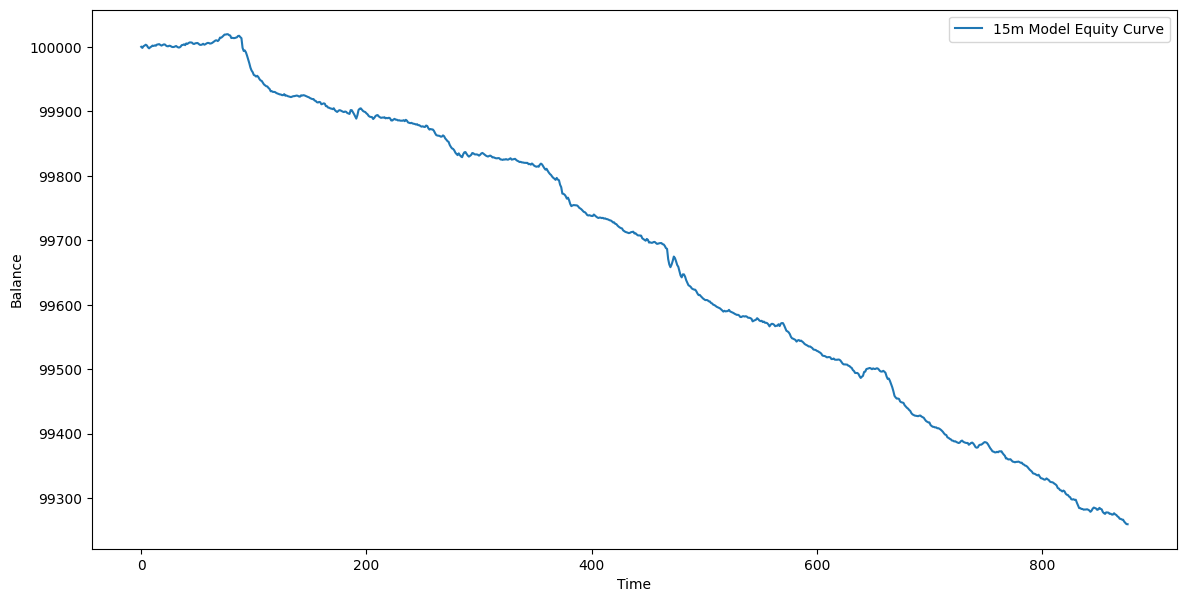

In [28]:
# Plot the equity curve
plt.figure(figsize=(14, 7))
plt.plot(equity_curve_15m, label='15m Model Equity Curve')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.legend()
plt.show()

## 6. Evaluation and Metrics



In [29]:
# Display the final equity curve and statistics
def display_performance(equity_curve):
    final_balance = equity_curve[-1]
    total_return = (final_balance - initial_balance) / initial_balance * 100
    max_drawdown = calculate_drawdown(equity_curve).max() * 100
    print(f'Final Balance: ${final_balance:.2f}')
    print(f'Total Return: {total_return:.2f}%')
    print(f'Max Drawdown: {max_drawdown:.2f}%')

In [30]:
# Display performance for the model
display_performance(equity_curve_15m)

Final Balance: $99259.63
Total Return: -0.74%
Max Drawdown: 0.76%


In [31]:
# Additional Metrics
def calculate_metrics(equity_curve):
    returns = np.diff(equity_curve) / equity_curve[:-1]
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252 * 24)  # Annualized Sharpe Ratio assuming 252 trading days and 24 15-min intervals per day
    max_drawdown = calculate_drawdown(equity_curve).max() * 100
    return sharpe_ratio, max_drawdown

In [32]:
# Collect and display additional metrics
sharpe_ratio, max_drawdown = calculate_metrics(equity_curve_15m)
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Max Drawdown: {max_drawdown:.2f}%')

Sharpe Ratio: -34.37
Max Drawdown: 0.76%


## 7. Conclusion and Suggestions for Further Improvement

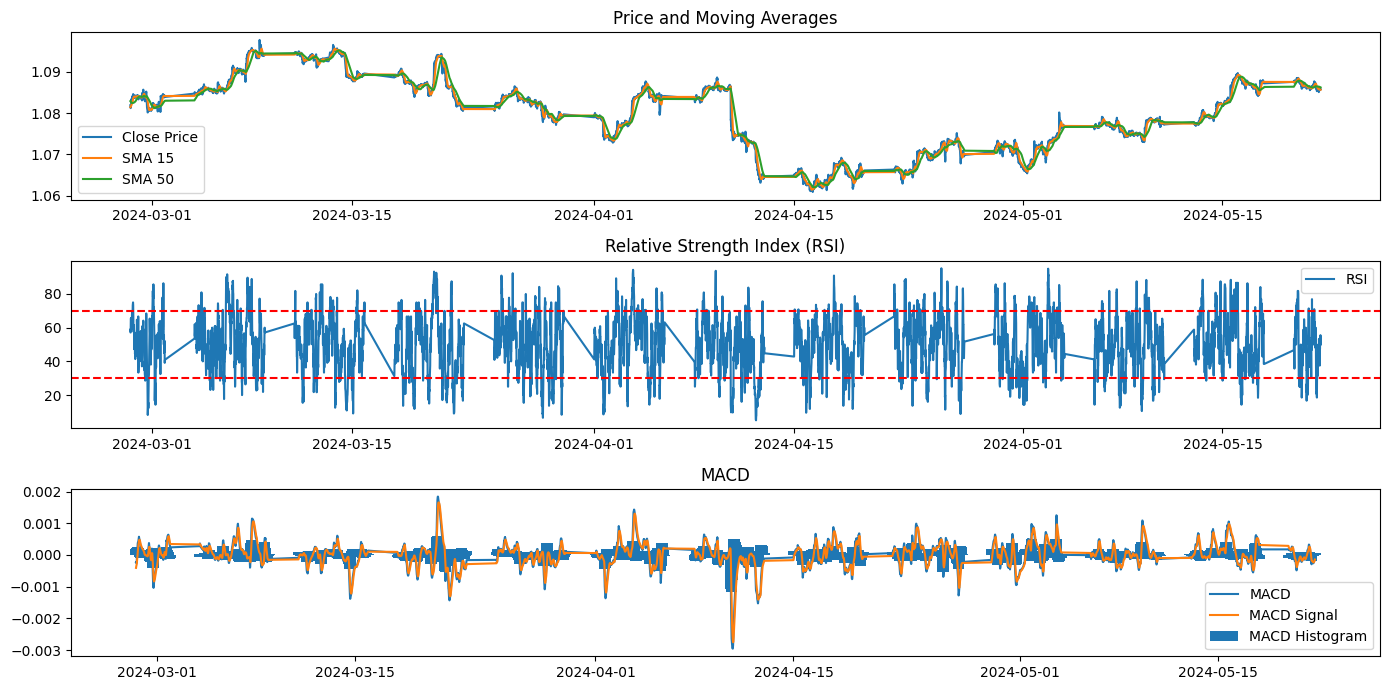

In [33]:
# Plot additional visualizations for better insights
def plot_indicators(data):
    plt.figure(figsize=(14, 7))
    plt.subplot(3, 1, 1)
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['SMA_15'], label='SMA 15')
    plt.plot(data['SMA_50'], label='SMA 50')
    plt.legend()
    plt.title('Price and Moving Averages')

    plt.subplot(3, 1, 2)
    plt.plot(data['RSI'], label='RSI')
    plt.axhline(30, color='r', linestyle='--')
    plt.axhline(70, color='r', linestyle='--')
    plt.legend()
    plt.title('Relative Strength Index (RSI)')

    plt.subplot(3, 1, 3)
    plt.plot(data['MACD'], label='MACD')
    plt.plot(data['MACD_signal'], label='MACD Signal')
    plt.bar(data.index, data['MACD_hist'], label='MACD Histogram')
    plt.legend()
    plt.title('MACD')

    plt.tight_layout()
    plt.show()

# Plot indicators for EUR/USD
plot_indicators(eurusd_15m)
